# Loading Dataset

In [111]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [1]:
import kagglehub
import shutil
import os

# Download latest version
data_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", data_path)

if not (os.path.exists('Plant Dataset')):
  shutil.copytree(data_path, 'Plant Dataset')

100%|██████████| 2.70G/2.70G [00:31<00:00, 91.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [34]:
train_data_path = '/content/Plant Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_data_path = '/content/Plant Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_data_path = '/content/Plant Dataset/test/test'

# Data Preprocessing

In [35]:
print(f"Number of Training Classes: {len(train_data_path)}")
print(f"Number of Validation Classes: {len(valid_data_path)}")
print(f"Number of Test Classes: {len(test_data_path)}")

Number of Training Classes: 104
Number of Validation Classes: 104
Number of Test Classes: 32


In [46]:
def creating_training_data(dataset_path):
  # Create empty dictionaries to make dataset
  image_path = []
  image_label = []

  # Iterate over the file names which are labels
  for label in os.listdir(dataset_path):
    # Join folder paths with labels
    path = os.path.join(dataset_path, label)

    if not os.path.isdir(path):
      image_path.append(path)
      label = label.split(".")[0]
      image_label.append(label)
      continue
    else:
      for image in os.listdir(path):
          image_path.append(os.path.join(path, image))
          image_label.append(label)

  return image_path, image_label

In [59]:
train_data, train_labels = creating_training_data(train_data_path)
print(f"Number of Images in Training Data: {len(train_data)}")
print(f"Number of Classes: {len(np.unique(train_labels))}")
print(f"Labels for Training Data: {train_labels[:5]}\n")

valid_data, valid_labels = creating_training_data(valid_data_path)
print(f"Number of Images in Training Data: {len(valid_data)}")
print(f"Number of Classes: {len(np.unique(valid_labels))}")
print(f"Labels for Validation Data: {valid_labels[:5]}\n")

test_data, test_labels = creating_training_data(test_data_path)
print(f"Number of Images in Training Data: {len(test_data)}")
print(f"Number of Classes: {len(np.unique(test_labels))}")
print(f"Labels for Training Data: {test_labels[:5]}\n")

Number of Images in Training Data: 70295
Number of Classes: 38
Labels for Training Data: ['Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight']

Number of Images in Training Data: 17572
Number of Classes: 38
Labels for Validation Data: ['Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight', 'Tomato___Late_blight']

Number of Images in Training Data: 33
Number of Classes: 33
Labels for Training Data: ['PotatoEarlyBlight5', 'TomatoYellowCurlVirus4', 'TomatoHealthy2', 'PotatoEarlyBlight2', 'PotatoEarlyBlight1']



# Visualization

In [48]:
from PIL import Image
import matplotlib.pyplot as plt


def display_image(data_paths):
  plt.figure(figsize=(15, 15))
  for i,image_path in enumerate(data_paths):
    image = Image.open(image_path)
    plt.subplot(1, len(data_paths), i + 1)
    plt.imshow(image)
    plt.axis('off')
  plt.show()

Training Images: 


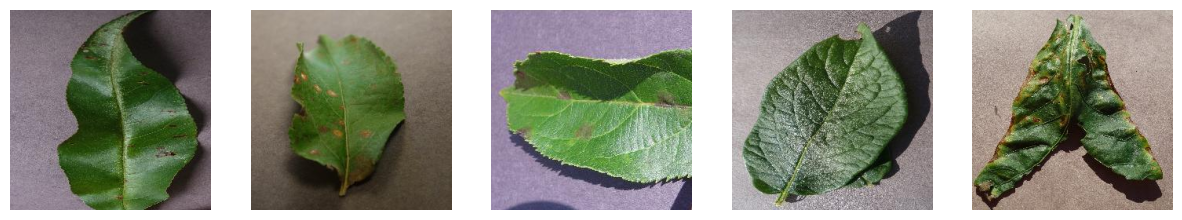

Validation Images: 


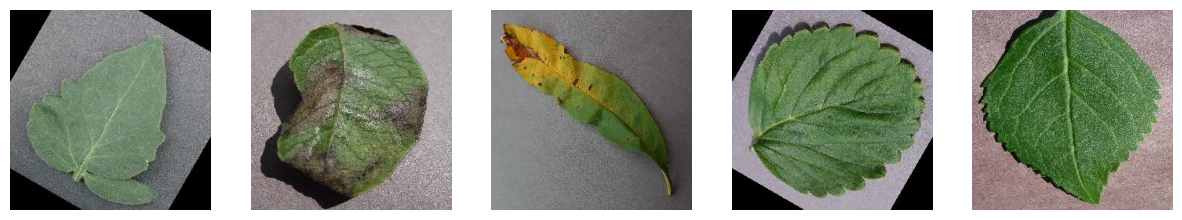

Test Images: 


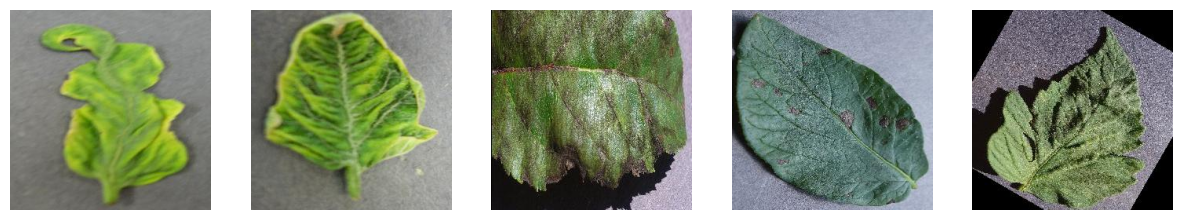

In [49]:
import random

print(f"Training Images: ")
display_image(random.sample(train_data,5))

print(f"Validation Images: ")
display_image(random.sample(valid_data,5))

print(f"Test Images: ")
display_image(random.sample(test_data,5))

# Workflow Functions

In [120]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import cv2

# Custom data generator
def custom_data_generator(image_paths, labels, batch_size, num_classes, input_shape):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_image_paths = image_paths[start:end]
            batch_labels = labels[start:end]

            images = []
            one_hot_labels = []
            for img_path, label in zip(batch_image_paths, batch_labels):
                # Load image and resize
                image = Image.open(img_path).resize(input_shape[:2])
                image = img_to_array(image) / 255.0  # Normalize pixel values
                images.append(image)

                # One-hot encode label
                one_hot_labels.append(to_categorical(label, num_classes))

            yield np.array(images), np.array(one_hot_labels)

# Training and Data Loader

In [129]:
import numpy as np
import random

# Custom data sampling function
def sample_data(data, labels, sample_size):
    indices = random.sample(range(len(data)), sample_size)
    sampled_data = [data[i] for i in indices]
    sampled_labels = [labels[i] for i in indices]
    return sampled_data, sampled_labels

# Training with reduced data per epoch
def fit_with_custom_generator(
    model,
    train_data,
    train_labels,
    valid_data,
    valid_labels,
    batch_size=32,
    epochs=10,
    sample_size=5000
):
    # Get the number of classes
    num_classes = len(np.unique(train_labels))

    # Map labels to integer indices for both training and validation labels
    label_to_index = {label: idx for idx, label in enumerate(sorted(set(train_labels)))}
    train_labels_int = [label_to_index[label] for label in train_labels]
    valid_labels_int = [label_to_index[label] for label in valid_labels]

    # Define steps per epoch based on sample size
    steps_per_epoch = sample_size // batch_size
    validation_steps = sample_size // batch_size

    # Training history
    history_all = []

    for epoch in range(epochs):
        # Sample a subset of training and validation data for this epoch
        sampled_train_data, sampled_train_labels = sample_data(train_data, train_labels_int, sample_size)
        sampled_valid_data, sampled_valid_labels = sample_data(valid_data, valid_labels_int, sample_size)

        # Create new generators for each epoch with sampled data
        train_generator = custom_data_generator(sampled_train_data, sampled_train_labels, batch_size, num_classes, (32, 32, 3))
        valid_generator = custom_data_generator(sampled_valid_data, sampled_valid_labels, batch_size, num_classes, (32, 32, 3))

        # Train the model for one epoch with the sampled data
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_generator,
            validation_steps=validation_steps,
            epochs=5,  # Single epoch per subset
            verbose=1
        )

        # Append history for analysis
        history_all.append(history.history)

    return model, history_all


# Custom Model (50 Epochs with 5000 sample size per epoch)

In [118]:
from tensorflow.keras import layers, models

# Custom CNN model definition
def create_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [119]:
import numpy as np

input_shape = np.array(Image.open(train_data[0])).shape
num_classes = len(np.unique(train_labels))

# Instantiate and compile the models
custom_cnn = create_custom_cnn((32,32,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
# Example of training with custom data generator
custom_cnn , custom_cnn_metrics = fit_with_custom_generator(custom_cnn, train_data, train_labels, valid_data, valid_labels, batch_size=128, epochs=10)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 777ms/step - accuracy: 0.4022 - loss: 1.9677 - val_accuracy: 0.5220 - val_loss: 1.6109
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 689ms/step - accuracy: 0.4272 - loss: 1.8958 - val_accuracy: 0.5374 - val_loss: 1.5733
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 651ms/step - accuracy: 0.4455 - loss: 1.8419 - val_accuracy: 0.5493 - val_loss: 1.5216
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 708ms/step - accuracy: 0.4710 - loss: 1.7610 - val_accuracy: 0.5495 - val_loss: 1.4850
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 687ms/step - accuracy: 0.4716 - loss: 1.7069 - val_accuracy: 0.5523 - val_loss: 1.4782
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 727ms/step - accuracy: 0.4663 - loss: 1.7713 - val_accuracy: 0.5497 - val_loss: 1.5050
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 707ms/step - accuracy: 0.4643 - loss: 1.7628 - val_accuracy: 0.5622 - val_loss: 1.4295
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 699ms/step - accuracy: 0.4872 - loss: 1.7148 - val_accuracy: 0.

# VGG-16 Fine Tuned Model (15 Epochs with 5000 sample size per epoch)

In [133]:
# Feature Extraction with VGG16 (freezing all layers)
def create_vgg16_feature_extractor(input_shape, num_classes):
    base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model_vgg.layers:
        layer.trainable = False  # Freeze all layers for feature extraction
    x = base_model_vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    vgg_feature_extractor_model = Model(inputs=base_model_vgg.input, outputs=x)
    return vgg_feature_extractor_model

vgg_feature_extractor_model = create_vgg16_feature_extractor((32,32,3), num_classes)
vgg_feature_extractor_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [134]:
# Example of training with custom data generator
vgg_feature_extractor_model, vgg_feature_extractor_model_metrics = fit_with_custom_generator(vgg_feature_extractor_model, train_data, train_labels, valid_data, valid_labels, batch_size=128, epochs=3)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.1678 - loss: 3.2186 - val_accuracy: 0.4393 - val_loss: 2.1505
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.4632 - loss: 1.9637 - val_accuracy: 0.5193 - val_loss: 1.7319
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.5505 - loss: 1.5837 - val_accuracy: 0.5585 - val_loss: 1.5474
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.6111 - loss: 1.3540 - val_accuracy: 0.5893 - val_loss: 1.4268
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.6440 - loss: 1.2252 - val_accuracy: 0.6063 - val_loss: 1.3492
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.6081 - loss: 1.3082 - val_accuracy: 0.6116 - val_loss: 1.2938
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.6377 - loss: 1.1833 - val_accuracy: 0.6252 - val_loss: 1.2496
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.6782 - loss: 1.0879 - val_accuracy: 0.6363 - val_loss:

# VGG-16 Feature Extracted Model (15 Epochs with 5000 sample size per epoch)

In [131]:
# Load VGG16 model for fine-tuning
def create_vgg16_model(input_shape, num_classes):
    base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape))
    for layer in base_model_vgg.layers[:-3]:  # Freeze all but the last 4 layers
        layer.trainable = False
    x = base_model_vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    vgg_model = Model(inputs=base_model_vgg.input, outputs=x)
    return vgg_model



# Instantiate and compile the models
vgg_model = create_vgg16_model((32,32,3), num_classes)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
# Example of training with custom data generator
vgg_model, vgg_model_metrics = fit_with_custom_generator(vgg_model, train_data, train_labels, valid_data, valid_labels, batch_size=128, epochs=3)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - accuracy: 0.2254 - loss: 2.8443 - val_accuracy: 0.4786 - val_loss: 1.7116
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - accuracy: 0.5376 - loss: 1.5006 - val_accuracy: 0.6123 - val_loss: 1.3139
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.6564 - loss: 1.0903 - val_accuracy: 0.6457 - val_loss: 1.1185
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - accuracy: 0.7382 - loss: 0.8400 - val_accuracy: 0.6420 - val_loss: 1.1703
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - accuracy: 0.7547 - loss: 0.7450 - val_accuracy: 0.6890 - val_loss: 1.0496
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 244s 6s/step - accuracy: 0.7113 - loss: 0.9276 - val_accuracy: 0.7382 - val_loss: 0.8329
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - accuracy: 0.7301 - loss: 0.8129 - val_accuracy: 0.7301 - val_loss: 0.8760
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - accuracy: 0.8041 - loss: 0.6108 - val_accuracy: 0.7365 - val_loss:

# ResNet-50 Fine Tuned Model (15 Epochs with 5000 sample size per epoch)

In [135]:
# Feature Extraction with ResNet50 (freezing all layers)
def create_resnet50_feature_extractor(input_shape, num_classes):
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model_resnet.layers:
        layer.trainable = False  # Freeze all layers for feature extraction
    x = base_model_resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    resnet_feature_extractor_model = Model(inputs=base_model_resnet.input, outputs=x)
    return resnet_feature_extractor_model


resnet_feature_extractor_model = create_resnet50_feature_extractor((32,32,3), num_classes)
resnet_feature_extractor_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [136]:
# Example of training with custom data generator
resnet_feature_extractor_model, resnet_feature_extractor_model_metrics = fit_with_custom_generator(resnet_feature_extractor_model, train_data, train_labels, valid_data, valid_labels, batch_size=128, epochs=3)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.0242 - loss: 4.0037 - val_accuracy: 0.0555 - val_loss: 3.6402
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.0433 - loss: 3.6631 - val_accuracy: 0.0872 - val_loss: 3.5314
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0705 - loss: 3.5534 - val_accuracy: 0.0893 - val_loss: 3.4457
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.0817 - loss: 3.4682 - val_accuracy: 0.0878 - val_loss: 3.3942
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0990 - loss: 3.3871 - val_accuracy: 0.0920 - val_loss: 3.3248
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0981 - loss: 3.3159 - val_accuracy: 0.1222 - val_loss: 3.2720
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1057 - loss: 3.3001 - val_accuracy: 0.1180 - val_loss: 3.2213
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1166 - loss: 3.2362 - val_accuracy: 0.1344 - val_loss: 3.1720


# ResNet-50 Feature Extracted Model (15 Epochs with 5000 sample size per epoch)

In [137]:
# Load ResNet50 model for fine-tuning
def create_resnet50_model(input_shape, num_classes):
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model_resnet.layers[:-10]:  # Freeze all but the last 10 layers
        layer.trainable = False
    x = base_model_resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    resnet_model = Model(inputs=base_model_resnet.input, outputs=x)
    return resnet_model

# Instantiate and compile the models
resnet_model = create_resnet50_model((32,32,3), num_classes)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [138]:
# Example of training with custom data generator
resnet_model, resnet_model_model_metrics = fit_with_custom_generator(resnet_model, train_data, train_labels, valid_data, valid_labels, batch_size=128, epochs=3)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.0816 - loss: 3.9390 - val_accuracy: 0.0280 - val_loss: 5.9800
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.2012 - loss: 2.8825 - val_accuracy: 0.0497 - val_loss: 5.6942
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.2921 - loss: 2.4569 - val_accuracy: 0.0265 - val_loss: 6.1157
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.3836 - loss: 2.0709 - val_accuracy: 0.0252 - val_loss: 8.4362
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.4765 - loss: 1.7572 - val_accuracy: 0.0248 - val_loss: 15.2878
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.3915 - loss: 2.1001 - val_accuracy: 0.0248 - val_loss: 8.3303
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.4521 - loss: 1.8205 - val_accuracy: 0.0302 - val_loss: 13.5243
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.5527 - loss: 1.4395 - val_accuracy: 0.0441 - val_los

# Evaluation

## Individual Graphs

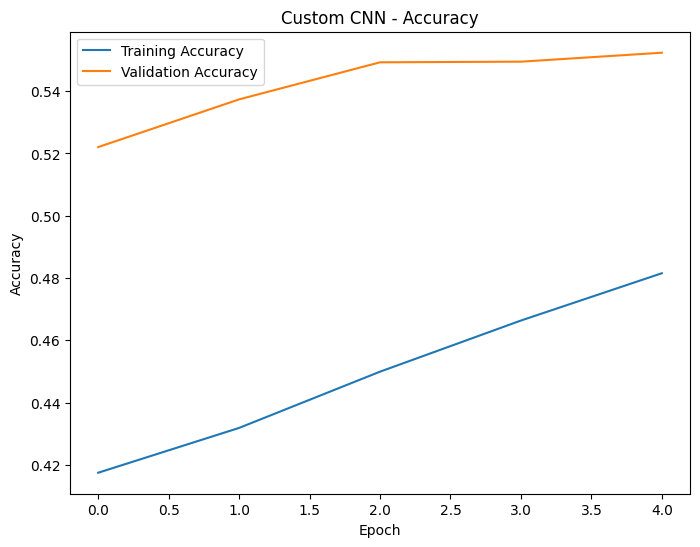

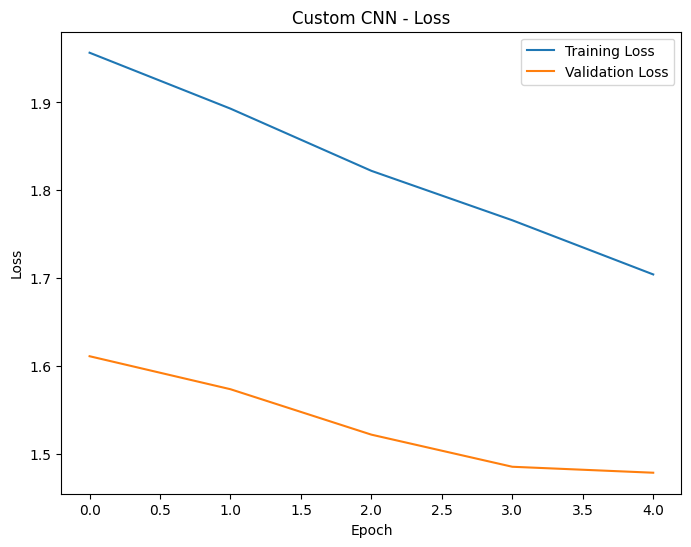

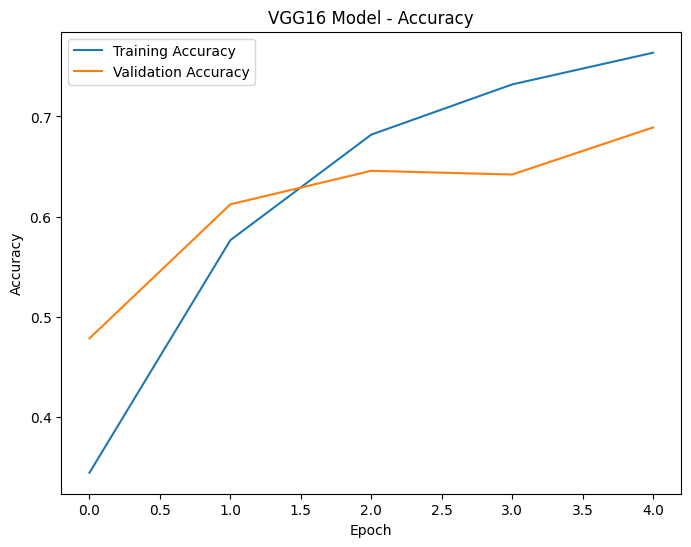

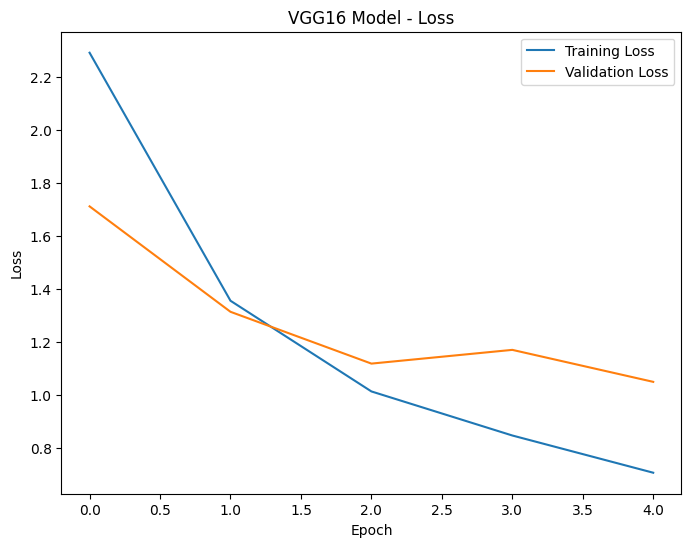

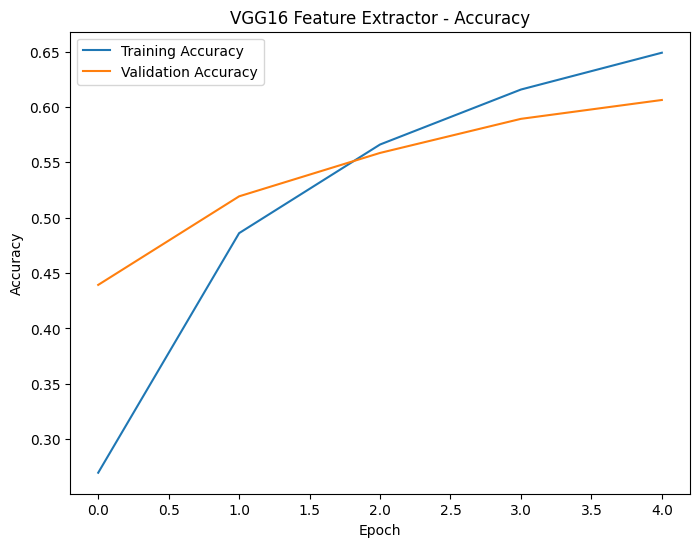

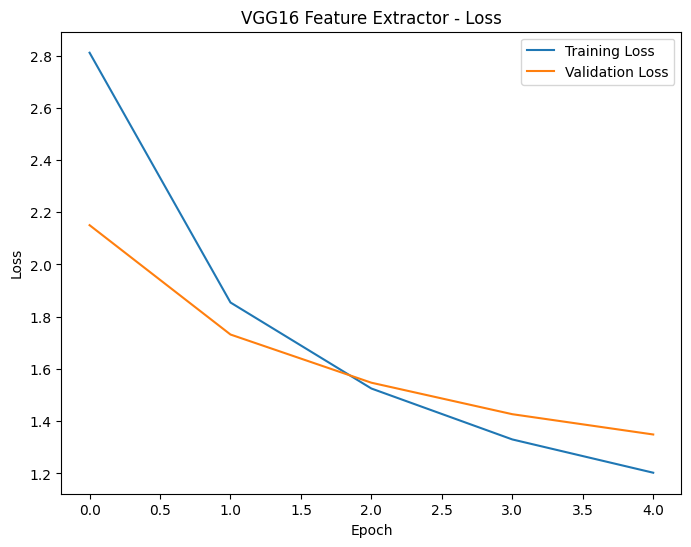

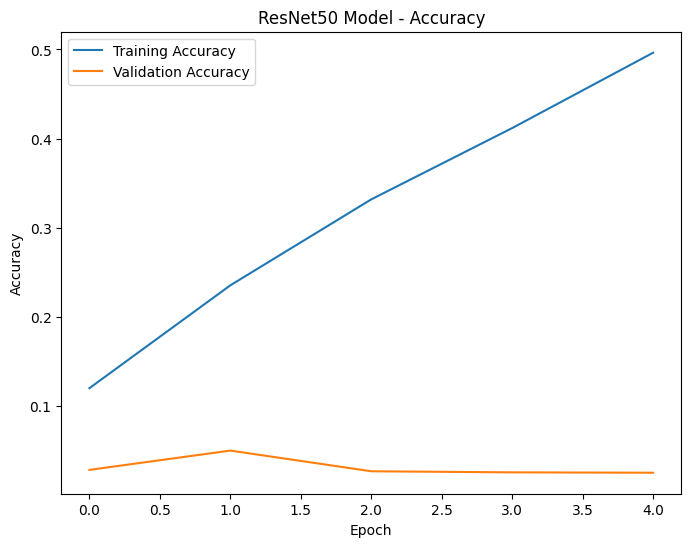

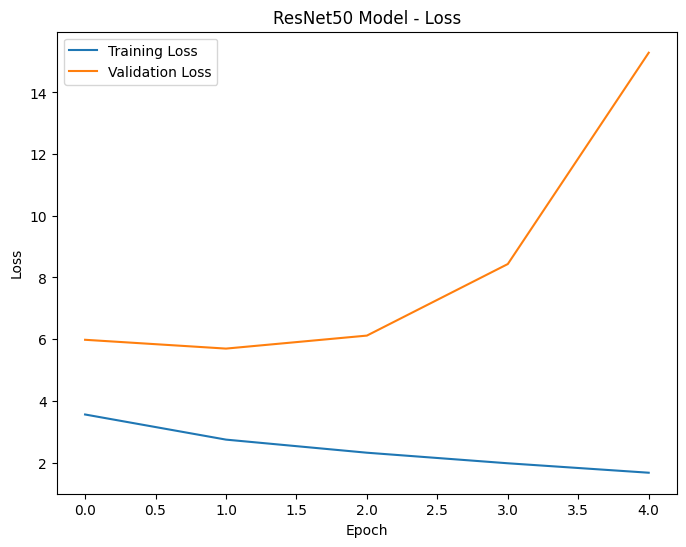

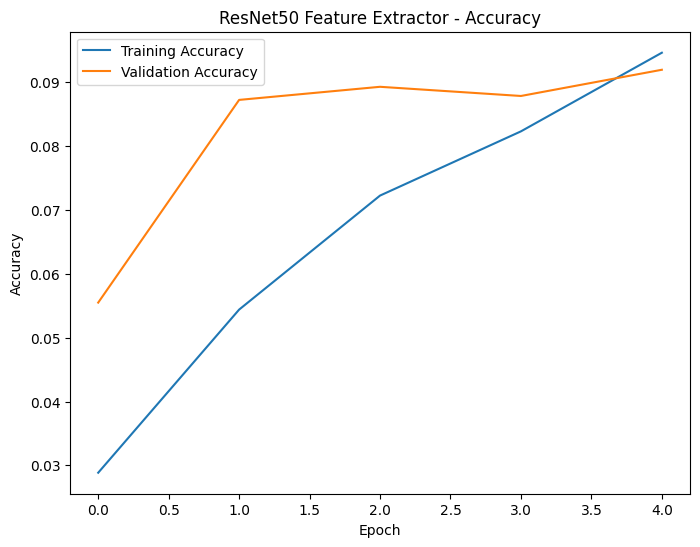

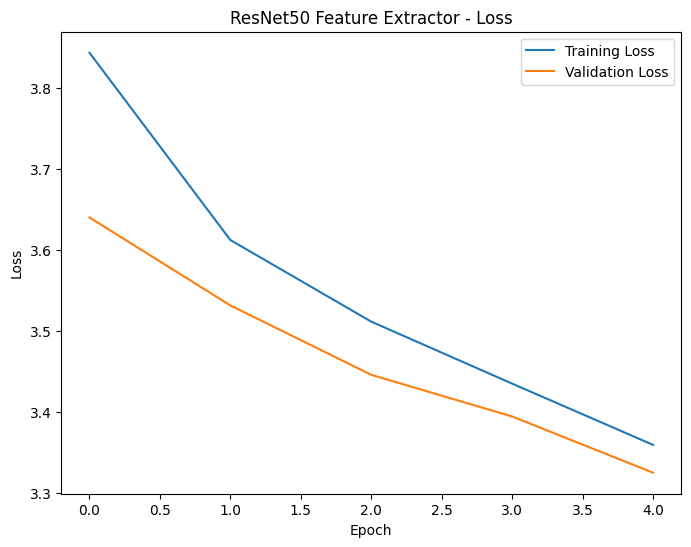

In [149]:
import matplotlib.pyplot as plt

# Assuming metrics is a list of dictionaries with 'accuracy', 'val_accuracy', 'loss', and 'val_loss' keys
metrics = [custom_cnn_metrics, vgg_model_metrics, vgg_feature_extractor_model_metrics, resnet_model_model_metrics, resnet_feature_extractor_model_metrics]
model_names = ['Custom CNN', 'VGG16 Model', 'VGG16 Feature Extractor', 'ResNet50 Model', 'ResNet50 Feature Extractor']

# Loop through each model's metrics and create individual plots
for i, model_metrics in enumerate(metrics):
    # Extract metrics for the current model
    accuracy = model_metrics[0]['accuracy']
    val_accuracy = model_metrics[0]['val_accuracy']
    loss = model_metrics[0]['loss']
    val_loss = model_metrics[0]['val_loss']

    # Create a figure for the current model's accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_names[i]} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

    # Create a figure for the current model's loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_names[i]} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()


## Combined Graphs

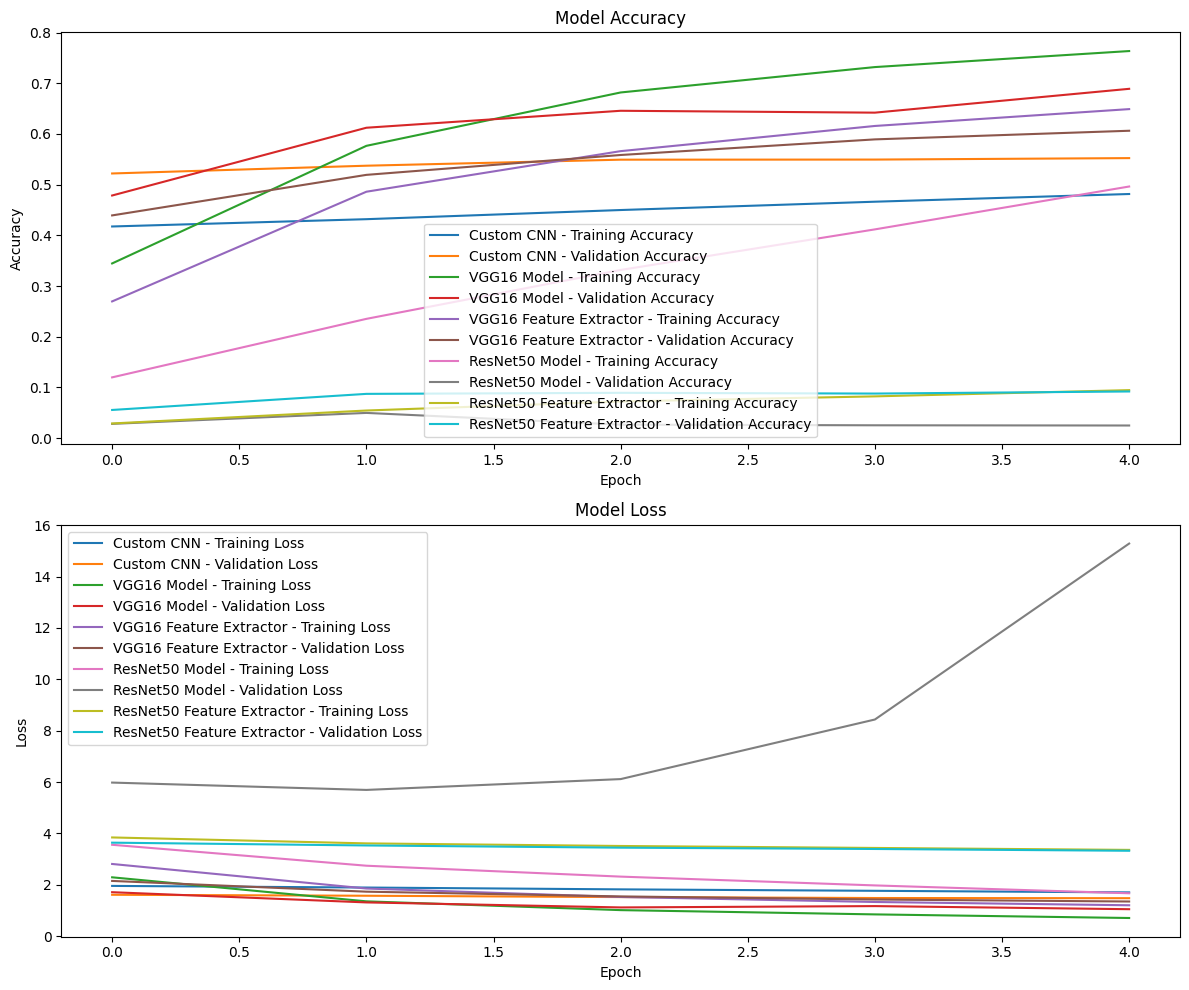

In [148]:
import matplotlib.pyplot as plt

# Assuming metrics is a list of dictionaries with 'accuracy', 'val_accuracy', 'loss', and 'val_loss' keys
# Each dictionary corresponds to one model, and model_names contains names for each model
metrics = [custom_cnn_metrics, vgg_model_metrics, vgg_feature_extractor_model_metrics, resnet_model_model_metrics, resnet_feature_extractor_model_metrics]
model_names = ['Custom CNN', 'VGG16 Model', 'VGG16 Feature Extractor', 'ResNet50 Model', 'ResNet50 Feature Extractor']

# Set up the figure for subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Loop through each model's metrics and plot
for i, model_metrics in enumerate(metrics):
    # Extract metrics for the current model
    accuracy = model_metrics[0]['accuracy']
    val_accuracy = model_metrics[0]['val_accuracy']
    loss = model_metrics[0]['loss']
    val_loss = model_metrics[0]['val_loss']

    # Plot accuracy
    axs[0].plot(accuracy, label=f'{model_names[i]} - Training Accuracy')
    axs[0].plot(val_accuracy, label=f'{model_names[i]} - Validation Accuracy')

    # Plot loss
    axs[1].plot(loss, label=f'{model_names[i]} - Training Loss')
    axs[1].plot(val_loss, label=f'{model_names[i]} - Validation Loss')

# Set titles and labels for each subplot
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='best')

axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()


# Dataset Explanation

## Dataset Overview

The dataset, [New Plant Diseases Dataset](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset), is designed for image classification tasks in the domain of plant pathology. It contains images of various plant leaves, each labeled with a specific disease or healthy status, making it suitable for training deep learning models to identify plant diseases.

### Dataset Structure
- **Training Set**: Contains 38 categories, each representing a different disease or healthy condition for various plant species.
- **Validation Set**: Mirrors the training set categories, providing images for model validation and performance tuning.
- **Testing Set**: Independent dataset for final performance evaluation, following the same label distribution.

### Categories
The dataset covers **38 classes** across multiple plant species, including common conditions like "Tomato___Late_blight," "Apple___Black_rot," and "Grape___Esca," as well as healthy classes (e.g., "Peach___healthy").

### Image Format
- **Resolution**: High-resolution images, reduced to `(32, 32)` from `(256, 256)` during training due to compute constraints.
- **Format**: JPEG images, resized for memory efficiency and faster processing.

### Usage
This dataset is suitable for:
1. **Classification Tasks**: Predicting disease types from leaf images.
2. **Transfer Learning**: Adapting pretrained models like VGG16 and ResNet50 to classify plant diseases.
3. **Feature Extraction**: Using models with frozen layers to extract features for further analysis.

By leveraging this structured dataset, models can effectively learn disease patterns across different plant species, aiding in agricultural and horticultural research.


# Description and Pipeline


### Objective
This lab focuses on training and fine-tuning deep learning models on image data with computational efficiency. Given compute constraints, image resolutions are downsized to manage memory and speed up processing.

### Data Preprocessing
1. **Data Loading**: Custom functions load image paths and labels from directories, generating one-hot encoded labels.
2. **Custom Data Generator**: A generator resizes images to `(32, 32)` and normalizes them for batch processing. Smaller images reduce memory usage and enhance processing speed.

### Model Architectures
1. **Custom CNN**:
   - **Architecture**: Consists of 3 Conv2D layers (32, 64, 128 filters), each followed by MaxPooling.
   - **Fully Connected Layers**: Two dense layers with 512 and 128 units, including dropout for regularization.
   - **Output Layer**: Softmax layer for multi-class classification.

2. **VGG16**:
   - **Feature Extraction**: Freezes all layers of a pretrained VGG16 for fixed feature extraction.
   - **Fine-Tuning**: Allows training on the last 3 layers for adaptation to new data.
   - **Input Shape**: Adjusted to `(32, 32, 3)` for resource compatibility, with the option to upscale to `(224, 224, 3)` for improved accuracy if resources permit.

3. **ResNet50**:
   - **Feature Extraction**: Freezes all layers of a pretrained ResNet50 model.
   - **Fine-Tuning**: Enables training on the last 10 layers to adapt to new data.
   - **Input Shape**: Similar resizing considerations as with VGG16.

### Training Process
A custom training function samples a subset of data per epoch, reducing the training dataset size to minimize computational load while preserving model efficacy. Fine-tuning is carried out with the `Adam` optimizer and a reduced learning rate for stability.

This approach balances model complexity with downsized image inputs to achieve efficient training given compute limitations.


# Analysis and Comparison of Results:

1. **Custom CNN**:
   - The accuracy for both training and validation is relatively low compared to the other models, starting around **0.42** and showing a slow, modest increase over epochs.
   - This suggests that the **Custom CNN model might not be complex enough** to capture the features required for high performance in this task or might need further tuning (e.g., increasing depth or adjusting hyperparameters).

2. **VGG16 Model**:
   - The VGG16 model shows significantly better performance than the Custom CNN, with a steady increase in both training and validation accuracy over epochs.
   - Training accuracy reaches above **0.7**, and validation accuracy is around **0.65**, indicating that this model generalizes better.
   - This suggests that **VGG16’s pre-trained structure provides a solid starting point for feature extraction**, which improves performance on this task.

3. **VGG16 Feature Extractor**:
   - The VGG16 Feature Extractor model has a similar trend to the VGG16 Model but performs slightly lower in both training and validation.
   - The model starts with low accuracy but increases quickly, indicating that it may benefit from fine-tuning or additional training epochs.
   - This could imply that while **VGG16’s layers are useful for this task, allowing some layers to be trainable might yield even better results**.

4. **ResNet50 Model**:
   - The ResNet50 model starts with a lower initial accuracy but has a steady upward trend, reaching higher training and validation accuracies than the Custom CNN but lower than the VGG16-based models.
   - This suggests that while **ResNet50 captures useful features**, its performance may benefit from fine-tuning to match VGG16’s performance.

5. **ResNet50 Feature Extractor**:
   - The ResNet50 Feature Extractor model shows a gradual increase in accuracy, similar to ResNet50 but with slightly lower values in both training and validation.
   - As with the VGG16 Feature Extractor, this might imply that making some layers trainable or fine-tuning the ResNet50 model could improve performance.


### General Observations

- **Best Model**: The **VGG16 model** (without feature extraction ) performs the best overall, reaching the highest training and validation accuracies. This indicates that VGG16’s architecture, perhaps with fine-tuning, is well-suited for this task.
- **Feature Extraction**: Both the VGG16 and ResNet50 feature extractor models perform slightly worse than their corresponding full models. This suggests that allowing the models to train additional layers may help improve performance.
- **Custom CNN**: The custom architecture’s lower accuracy suggests it may need more complexity or further tuning to achieve competitive performance.

